
# Tvorba zvuku pomocí syntézy pro hru obdobnou stylophonu (vlastní projekt ISS)

## Úvod

V tomto projektu chci experimentovat s generováním zvuku, který potřebuji pro moji hru. Hra (aplikace) je inspirována hudebním nástrojem stylophone. Obsahuje 2d dotykovou plochu. Pozice doteku na ose X určuje tón (frekvenci), osa Y určuje modifikaci tónu. Cílem tohoto projektu bylo naimplementovat takovou aplikaci.
Tento jupyer python book slouží k pokusúm. Zbytek implementace se nachází přímo ve vytvořené aplikaci. 


## Import potřebných knihoven


In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pydub

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import (
    display, clear_output)
import sys
from pydub import AudioSegment
from random import randrange
%matplotlib inline

# REPLACE Audio with Ipython.display.Audio if not using VSCODE jupyter extension
from IPython.display import Audio
# from vscode_audio import Audio

## Analýza a pokus o umělé vytvoření již vytvořeného tónu (zvuku).

Ačkoliv square wave zní o dost výrazněji, jak sine wave, stále to není ono. Zalíbil se mně zvuk, který dělá tento stylophone [video](https://www.youtube.com/watch?v=Jmmzl52EphU) (stylophone dělá pořad stejný zvuk, klasický sine/square nebo saw wave, ale tato osoba používá postprocessing, aby dosáhla lepšího zvuku. Z ostatních videí lze pozorovat, že konrétně používá přístroj [DIGITECH Whammy](https://www.digitech.com/whammy-pitch/), který přidává různé efekty k audiu. Bohužel jsem nenašel, co přesně vnitřně za modifikace dělá)

Rozhodl jsem se zvuk zanalyzovat, abych zjistil, co ho dělá tolik výraznější. Vybral jsem jeden z tónů, které ve videu zazní od času 2:20, neboť tam v pozadí nejsou slyšet žádne doprovodné nástroje. Extrahovaný zvuk tak není rušen. YT video jsem stáhl a za pomocí programu [ffmpeg](https://www.ffmpeg.org/) jsem extrahoval daný tón.

V následujícím kódu zvuk načtu, ořežu pouze na část toho tónu a vykreslím jeho "waveform", poté přiblížím, a následně ho přehraji.

fs: 44100


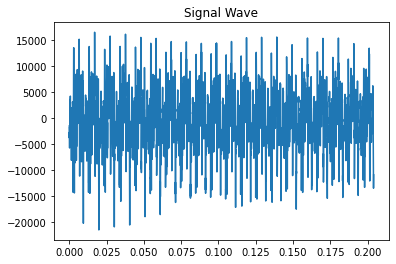

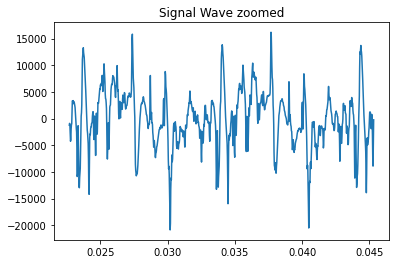

In [2]:
sound = AudioSegment.from_file("stylophone_note_to_examine.aac")
sound = sound.set_channels(1)
# Sampling rate of sound
fs = sound.frame_rate
wave = sound.get_array_of_samples()
wave = wave[14000:23000]

print(f"fs: {fs}")

time = np.linspace(0, len(wave) / fs, num=len(wave))

plt.figure(1)
plt.title("Signal Wave")
plt.plot(time, wave)
plt.show()

plt.figure(1)
plt.title("Signal Wave zoomed")
plt.plot(time[1000:2000], wave[1000:2000])
plt.show()

display(Audio(wave, rate=fs))

### FFT analýza

Signál zanalyzuji pomocí FFT, abych se dozvěděl, z jakých frekvencí je signál složen a byl poté schopen ho zrekonstruovat.
Tady jsem zapomněl definovat Xovou osu grafu. Bohužel osa grafu vyšla tak nešťasntně, že frekvence vycházely násobku 17.32 hz, což je nota C#0, tudíž jsem v pravost výsledku věřil a později se spálil. Naštěstí jsem chybu pár dní poté odhalil a opravil.

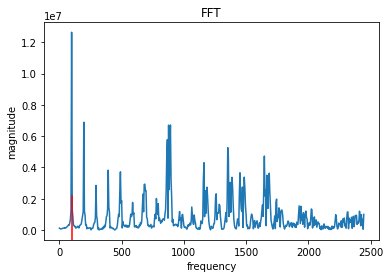

In [3]:
fft = np.fft.fft(wave)

fft_mag = np.abs(fft) 

base_f = 98.0

plt.figure(2)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("magnitude")
fr = (np.array(range(0, (int)(fs * (len(wave)/fs)))) / (len(wave) / fs) )
plt.plot(fr[:500], fft_mag[:500])
plt.axvline(x=98, color='red', ymax=0.2)
plt.show()


Jak si můžeme všimnout, nejvýraznější frekvencí v grafu je frekvence 98 hz. Následují další frekvence. Jenže když se podíváme pozorně, zjistíme, že první frekvence jsou pouze násobkem té předchozí. Na násobcích původní frekvence vykreslím červené vertikální čáry.

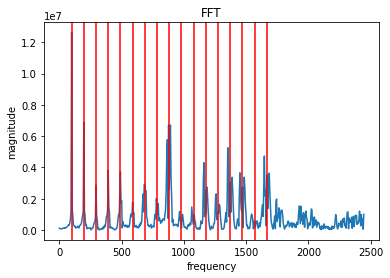

In [4]:
plt.figure(3)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.plot(fr[:500], fft_mag[:500])
for i in range(1, 18):
    plt.axvline(x=i*98, color='red')
plt.show()

Z výsledku vidíme, že prvních přibližně 6 násobků původní frekvence stojí samostatně, jenže pak násobky mají dominantní frekvenci těsně před a za násobkem.
V následujícím kódu zkouším zrekonstruovat prvních 9 frekvencí. Následně ke zvuku přidávám nějaký ten bílý šum.

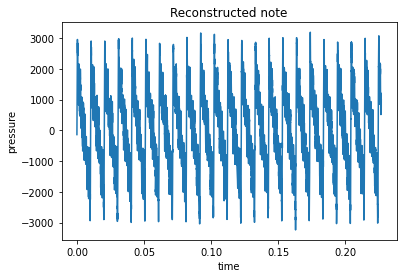

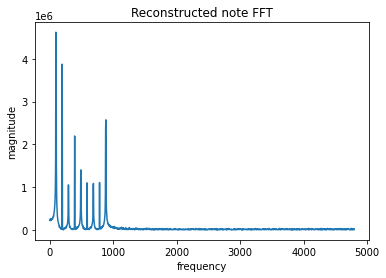

In [5]:
duration = 0.25
fs = 44100
base_f = 98.0
t = np.linspace(0., duration, int(fs * duration))

# Create signals on the 
notes =  [1300 * np.sin(2 * np.pi * base_f * t),
        700 * np.sin(2 * np.pi * 2*base_f * t),
        300 * np.sin(2 * np.pi * 3*base_f * t),
        400 * np.sin(2 * np.pi * 4*base_f * t),
        400 * np.sin(2 * np.pi * 5*base_f * t),
        200 * np.sin(2 * np.pi * 6*base_f * t),
        300 * np.sin(2 * np.pi * 7*base_f * t),
        200 * np.sin(2 * np.pi * 8*base_f * t),
        700 * np.sin(2 * np.pi * 9*base_f * t)]


mean = 0
std = 150 
num_samples = len(notes[0])
white_noise = np.random.normal(mean, std, size=num_samples)

# for i in range(0, len(notes)):
#     notes[i] = np.array([1 if x >= 0 else -1 for x in notes[i]])

note = notes[0]
for nt in notes[1:]:
    note += nt

#add white noise
note += white_noise

display(Audio(note, rate=fs))

plt.figure(3)
plt.title("Reconstructed note")
plt.xlabel("time")
plt.ylabel("pressure")
plt.plot(t[:10000], note[:10000])
plt.show()

fft_note = np.fft.fft(note)
fft_note_mag = np.abs(fft_note)

plt.figure(4)
plt.title("Reconstructed note FFT")
plt.xlabel("frequency")
plt.ylabel("magnitude")

fr = (np.array(range(0, (int)(fs * duration))) / duration)

plt.plot(fr[:1200], fft_note_mag[:1200])
plt.show()

Jak můžeme slyšet, na to, že jsem zrekonstruoval pouze prvních pár frekvencí, rekonstruovaný zvuk začíná být velmi podobný originálu.

Z tohoto je patrné, že zvuk tónu můžeme modifikovat pomocí dalších frekvencí stejného násobku základní frekvence.
To se nicméně dá skvěle využít pro modifikaci zvuku v mé hře na osu Y. Oproti klasickému přechodu ze sine na square wave je toto více výraznější. Pomocí dolní propusti nebo změnou poměru frekvencí můžu propustit pouze základní frekvenci, která bude znít jako klasický sine wave a postupným zvyšováním se můžu dostat k mnohem výraznějšímu zvuku.

Ono nicméně když se podíváme třeba na takový square wave a uděláme nad ním FFT, zjisíme, že se taky ve finále skládá z více frekvencí. Pravděpodobně proto je jeho zvuk výraznější

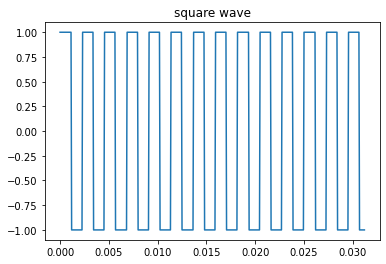

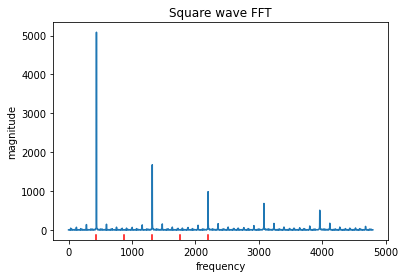

In [166]:
fs = 16000.
duration = 0.5
t = np.linspace(
    0., duration, int(fs * duration))

f = 440.0

sound: np.ndarray = np.sin(f * 2. * np.pi * t)

# Make it square instead of sine
sound = np.array([1 if x >= 0 else -1 for x in sound])

display(Audio(sound, rate=fs))
plt.figure(5)
plt.title("square wave")
plt.plot(t[:500], sound[:500])
plt.show()


fft_sound = np.fft.fft(sound)
fft_sound_mag = np.abs(fft_sound)

plt.figure(4)
plt.title("Square wave FFT")
plt.xlabel("frequency")
plt.ylabel("magnitude")

fr = (np.array(range(0, (int)(fs * duration))) / duration)

plt.plot(fr[:2400], fft_sound_mag[:2400])

for i in range(1, 6):
    plt.axvline(x=i*f, color='red', ymax=0.02)

plt.show()
